In [5]:
# STEP 1: Clean uninstall
!pip uninstall -y spacy thinc numpy

# STEP 2: Reinstall the compatible versions
!pip install numpy==1.26.4
!pip install spacy==3.7.2
!pip install thinc==8.2.2

# STEP 3: Download English model again
!python -m spacy download en_core_web_sm

# STEP 4: Verify everything is working
import numpy
import spacy

print("✅ NumPy version:", numpy.__version__)
print("✅ SpaCy version:", spacy.__version__)

nlp = spacy.load("en_core_web_sm")
print("✅ SpaCy model loaded successfully!")


Found existing installation: spacy 3.8.7
Uninstalling spacy-3.8.7:
  Successfully uninstalled spacy-3.8.7
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: numpy 2.3.4
Uninstalling numpy-2.3.4:
  Successfully uninstalled numpy-2.3.4


You can safely remove it manually.


   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   -----------------

Veridia.Io Internship Task

In [7]:

import os
import re
import string
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# interactive
import plotly.express as px
import plotly.graph_objects as go

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# NLP helpers (optional)
# pip install spacy
# python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', 400)


In [8]:
# Cell 2: load dataset
# Update path as needed
df = pd.read_csv("Resume.csv")   # or /kaggle/input/.../Resume.csv
df.shape, df.columns


((2484, 4),
 Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object'))

In [9]:
# Quick peek
df.head(5)
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,2484.0,NaN,NaN,NaN,31826159.293881,21457345.620455,3547447.0,17544295.5,25210313.0,36114441.0,99806115.0
Resume_str,2484,2482,"STOREKEEPER II Professional Summary The purpose of this document is to secure a responsible career position that fully utilizes educational knowledge and experience while contributing to the goals and values of this organization. Having a friendly attitude and worm personality is an appreciated strong point, as it aided in building positive relationships with customers. As a ...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Resume_html,2484,2482,"<div class=""fontsize fontface vmargins hmargins linespacing pagesize"" id=""document""> <div class=""section firstsection"" id=""SECTION_NAME515694141"" style=""\n padding-top:0px;\n ""> <div class=""paragraph PARAGRAPH_NAME firstparagraph"" id=""PARAGRAPH_515694141_1_336694356""> <div class=""name"" itemprop=""name""> <span class=""field"" id=""515694141FNAM1""> </span> <span> </span> <span class=""field"" ...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,2484,24,INFORMATION-TECHNOLOGY,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 1. missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing = pd.DataFrame({'missing_count': missing, 'missing_pct': missing/len(df)*100})
missing.head(20)


,missing_count,missing_pct
ID,0,0.0
Resume_str,0,0.0
Resume_html,0,0.0
Category,0,0.0


In [11]:
# Example cleaning rules
# 1) Drop columns that are mostly empty (customize threshold)
threshold_pct = 50
cols_to_drop = missing[missing['missing_pct'] > threshold_pct].index.tolist()
print("Dropping columns:", cols_to_drop)
df = df.drop(columns=cols_to_drop, errors='ignore')

# 2) Fill text fields with empty string
text_cols = [c for c in df.columns if df[c].dtype == 'object']
for c in text_cols:
    df[c] = df[c].fillna("")

# 3) Remove exact duplicates (by full resume text if available)
if 'Resume' in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=['Resume'])
    print(f"dropped {before - len(df)} exact duplicates based on Resume")
else:
    before = len(df)
    df = df.drop_duplicates()
    print(f"dropped {before - len(df)} duplicates (generic)")


Dropping columns: []
dropped 0 duplicates (generic)


In [12]:
# Text cleaning functions
email_pattern = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b')
phone_pattern = re.compile(r'(\+?\d{1,3})?[\s\-\(\)]{0,2}\d{3,4}[\s\-\)]{0,2}\d{3,4}[\s\-]?\d{0,4}')
url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')

def clean_text(text: str) -> str:
    text = str(text)
    # Remove email, phone, urls
    text = email_pattern.sub(' ', text)
    text = phone_pattern.sub(' ', text)
    text = url_pattern.sub(' ', text)
    # Remove punctuation
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'[_\-\.\,\(\)\[\]\{\}\:]+', ' ', text)
    # lowercase
    text = text.lower()
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
if 'Resume' in df.columns:
    df['resume_clean'] = df['Resume'].apply(clean_text)
else:
    # if there is combined text column like 'text' or 'Full Resume'
    candidate_text_col = next((c for c in df.columns if 'resume' in c.lower() or 'cv' in c.lower() or 'text' in c.lower()), None)
    if candidate_text_col:
        df['resume_clean'] = df[candidate_text_col].apply(clean_text)
    else:
        # fallback: join object columns as text
        df['resume_clean'] = df[text_cols].astype(str).agg(' '.join, axis=1).apply(clean_text)

df['resume_len_chars'] = df['resume_clean'].apply(len)
df['resume_len_words'] = df['resume_clean'].apply(lambda x: len(x.split()))
df[['resume_len_chars','resume_len_words']].describe()


,resume_len_chars,resume_len_words
count,2484.000000,2484.000000
mean,5779.865137,811.652979
std,2614.251806,374.123495
min,0.000000,0.000000
25%,4698.000000,650.000000
50%,5404.000000,755.000000
75%,6678.500000,932.000000
max,34392.000000,5187.000000


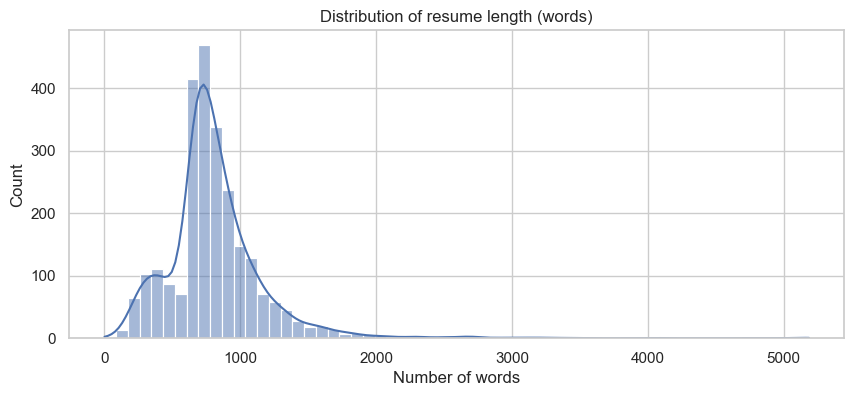

Very short resumes: 1
Very long resumes: 2


In [13]:
# Visualize length distribution
plt.figure(figsize=(10,4))
sns.histplot(df['resume_len_words'], bins=60, kde=True)
plt.title("Distribution of resume length (words)")
plt.xlabel("Number of words")
plt.show()

# Flag very short or very long resumes
short_mask = df['resume_len_words'] < 20
long_mask = df['resume_len_words'] > 5000   # tune threshold
print("Very short resumes:", short_mask.sum())
print("Very long resumes:", long_mask.sum())

# Optionally drop very short resumes
df = df[~short_mask].reset_index(drop=True)


In [14]:
# Starter skills list (extend this)
skill_keywords = [
    'python','java','c++','c#','sql','nosql','mongodb','postgresql','mysql',
    'spark','hadoop','pandas','numpy','scikit-learn','tensorflow','keras',
    'pytorch','nlp','computer vision','opencv','html','css','javascript',
    'react','angular','node','express','aws','azure','gcp','docker','kubernetes',
    'git','linux','bash','rest api','api','excel','power bi','tableau','matlab',
    'r programming','r','sas'
]
skill_keywords = [s.lower() for s in skill_keywords]

def extract_skills(text, skills_list=skill_keywords):
    text = text.lower()
    found = set()
    for s in skills_list:
        # word boundary or simple substring match
        if s in text:
            found.add(s)
    return list(found)

df['skills_found'] = df['resume_clean'].apply(lambda x: extract_skills(x, skill_keywords))
df['num_skills'] = df['skills_found'].apply(len)
df[['skills_found','num_skills']].head(10)


,skills_found,num_skills
0,"[r, aws]",2
1,"[git, r]",2
2,"[excel, express, sas, r]",4
3,"[excel, r]",2
4,"[excel, r, aws]",3
5,"[excel, r]",2
6,[r],1
7,"[r, aws]",2
8,"[excel, r, sas, aws]",4
9,"[r, aws]",2


In [15]:
# Count skill frequencies
skills_exploded = df.explode('skills_found')
skill_counts = skills_exploded['skills_found'].value_counts().reset_index()
skill_counts.columns = ['skill','count']
skill_counts.head(30)


,skill,count
0,r,2483
1,excel,1616
2,api,468
3,git,330
4,aws,302
5,sql,191
6,sas,182
7,html,154
8,express,111
9,java,98


In [16]:
fig = px.bar(skill_counts.head(20), x='skill', y='count', title='Top 20 Skills in Resumes', text='count')
fig.show()


In [17]:
degree_patterns = {
    'btech': r'\b(b\.?tech|btech|b\.?e|be|bsc|b\.?sc)\b',
    'mtech': r'\b(mtech|m\.?tech|m\.?e|ms|m\.?s|msc)\b',
    'mba': r'\b(mba)\b',
    'phd': r'\b(ph\.?d|phd)\b',
    'diploma': r'\b(diploma)\b'
}

def detect_degrees(text):
    degrees = []
    for k,p in degree_patterns.items():
        if re.search(p, text, flags=re.IGNORECASE):
            degrees.append(k)
    return degrees

df['degrees'] = df['resume_clean'].apply(detect_degrees)
df['has_degree'] = df['degrees'].apply(lambda x: len(x)>0)
df['degrees'].value_counts().head(20)


degrees
[]                         1021
[mtech]                     351
[btech]                     267
[diploma]                   247
[btech, mtech]              180
[btech, diploma]             91
[mtech, diploma]             74
[mba]                        71
[btech, mtech, diploma]      71
[mtech, mba]                 33
[btech, mba]                 31
[btech, mtech, mba]          19
[phd]                         8
[mba, diploma]                7
[mtech, mba, diploma]         4
[mtech, phd]                  3
[btech, phd]                  2
[btech, mtech, phd]           1
[btech, mba, diploma]         1
[mba, phd]                    1
Name: count, dtype: int64

In [18]:
def extract_experience_years(text):
    # Find patterns like '5 years', '3 yrs', '4+ years'
    matches = re.findall(r'(\d{1,2})\s*(?:\+)?\s*(?:years|yrs|year)', text, flags=re.I)
    if matches:
        # take max found as candidate experience
        years = [int(m) for m in matches]
        return max(years)
    # fallback: try "experience: 5" patterns
    matches2 = re.findall(r'experience\s*[:\-]?\s*(\d{1,2})', text, flags=re.I)
    if matches2:
        return int(matches2[0])
    return np.nan

df['exp_years'] = df['resume_clean'].apply(extract_experience_years)
df['exp_years'].describe()


count    1307.000000
mean       11.311400
std         9.830191
min         1.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        98.000000
Name: exp_years, dtype: float64

In [19]:
df['exp_years'] = df['exp_years'].fillna(-1)  # -1 means unknown


In [20]:
keep_cols = ['resume_clean','resume_len_words','resume_len_chars','skills_found','num_skills','degrees','has_degree','exp_years']
cleaned = df[keep_cols].copy()
cleaned.to_csv("resume_dataset_cleaned.csv", index=False)
print("Saved cleaned dataset: resume_dataset_cleaned.csv")


Saved cleaned dataset: resume_dataset_cleaned.csv


In [21]:
# Most common n-grams (helper)
def top_ngrams(corpus, n=None, ngram_range=(1,1), top_k=30):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

print("Top unigrams:", top_ngrams(cleaned['resume_clean'], ngram_range=(1,1), top_k=10))
print("Top bigrams:", top_ngrams(cleaned['resume_clean'], ngram_range=(2,2), top_k=10))


Top unigrams: [('state', 16156), ('company', 15212), ('city', 15077), ('management', 12174), ('sales', 8275), ('customer', 7927), ('business', 7866), ('skills', 7729), ('new', 6407), ('service', 6223)]
Top bigrams: [('city state', 14107), ('company city', 9903), ('customer service', 3062), ('project management', 1198), ('current company', 1177), ('microsoft office', 1145), ('university city', 1101), ('high school', 1069), ('business development', 914), ('communication skills', 841)]


In [24]:
# EDA Cell 1: imports (if not already imported)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', 300)


In [25]:
# EDA Cell 2: load cleaned data (or load original and adapt)
# If you have the cleaned CSV:
df = pd.read_csv("resume_dataset_cleaned.csv")
# If you have the 'cleaned' DataFrame in memory (from previous cell), you can skip the read.
df.shape, df.columns


((2483, 8),
 Index(['resume_clean', 'resume_len_words', 'resume_len_chars', 'skills_found',
        'num_skills', 'degrees', 'has_degree', 'exp_years'],
       dtype='object'))

In [26]:
# Basic info
print("Total resumes:", len(df))
print("Columns:", df.columns.tolist())

# Numeric summaries
display(df[['resume_len_words','resume_len_chars','num_skills','exp_years']].describe().T)

# How many resumes have degree info / experience known
print("Percent with detected degree:", df['has_degree'].mean()*100)
print("Percent with detected experience (exp_years >=0):", (df['exp_years']>=0).mean()*100)


Total resumes: 2483
Columns: ['resume_clean', 'resume_len_words', 'resume_len_chars', 'skills_found', 'num_skills', 'degrees', 'has_degree', 'exp_years']


,count,mean,std,min,25%,50%,75%,max
resume_len_words,2483.0,811.979863,373.843888,108.0,650.0,755.0,932.0,5187.0
resume_len_chars,2483.0,5782.192912,2612.202325,663.0,4699.5,5404.0,6682.0,34392.0
num_skills,2483.0,2.655658,1.713645,1.0,2.0,2.0,3.0,20.0
exp_years,2483.0,5.480467,9.415381,-1.0,-1.0,1.0,10.0,98.0


Percent with detected degree: 58.880386629077734
Percent with detected experience (exp_years >=0): 52.63793797825211


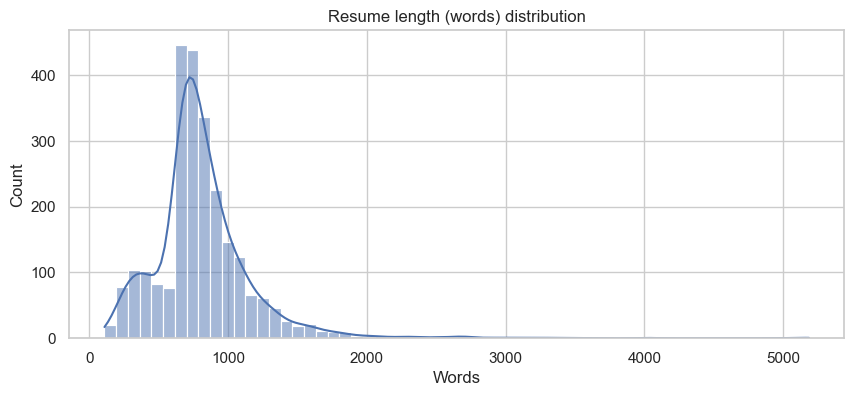

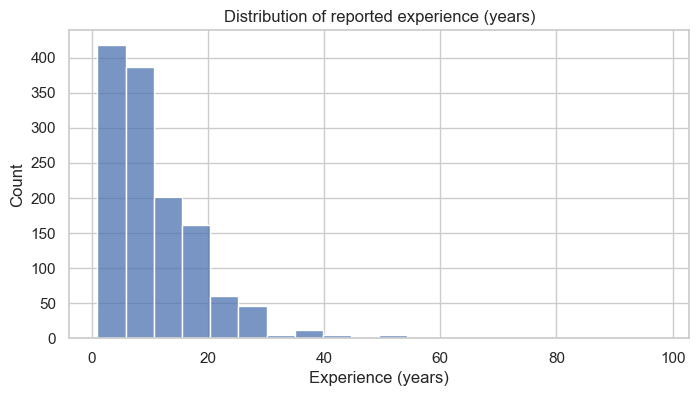

In [27]:
# Histogram: resume length
plt.figure(figsize=(10,4))
sns.histplot(df['resume_len_words'], bins=60, kde=True)
plt.title("Resume length (words) distribution")
plt.xlabel("Words")
plt.show()

# Experience distribution (exclude -1 unknown)
plt.figure(figsize=(8,4))
sns.histplot(df[df['exp_years']>=0]['exp_years'], bins=20, kde=False)
plt.title("Distribution of reported experience (years)")
plt.xlabel("Experience (years)")
plt.show()

# Interactive plotly version for experience
fig = px.histogram(df[df['exp_years']>=0], x='exp_years', nbins=20, title="Experience (years) - Interactive")
fig.show()


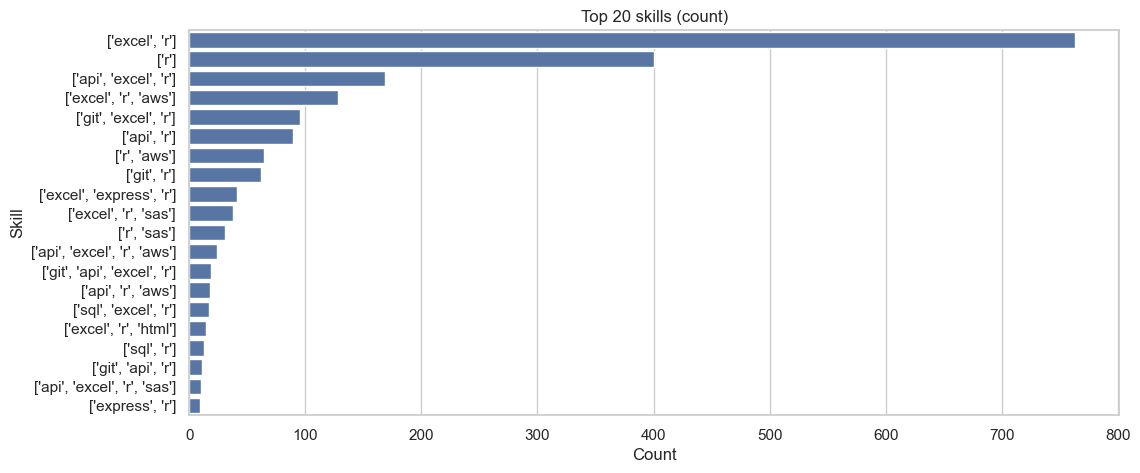

In [28]:
# explode skills and count
skills_exploded = df.explode('skills_found')
skill_counts = skills_exploded['skills_found'].value_counts().reset_index()
skill_counts.columns = ['skill','count']

# Top 20 barplot (static)
plt.figure(figsize=(12,5))
sns.barplot(data=skill_counts.head(20), x='count', y='skill')
plt.title("Top 20 skills (count)")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()

# Interactive top skills
fig = px.bar(skill_counts.head(30), x='skill', y='count', title='Top 30 Skills (Interactive)')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


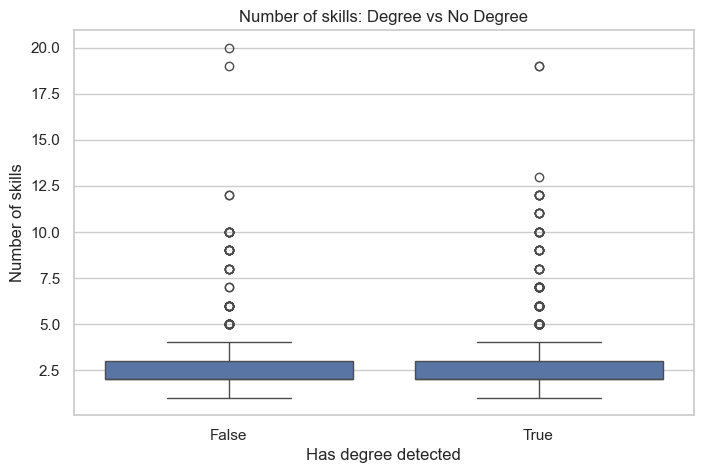

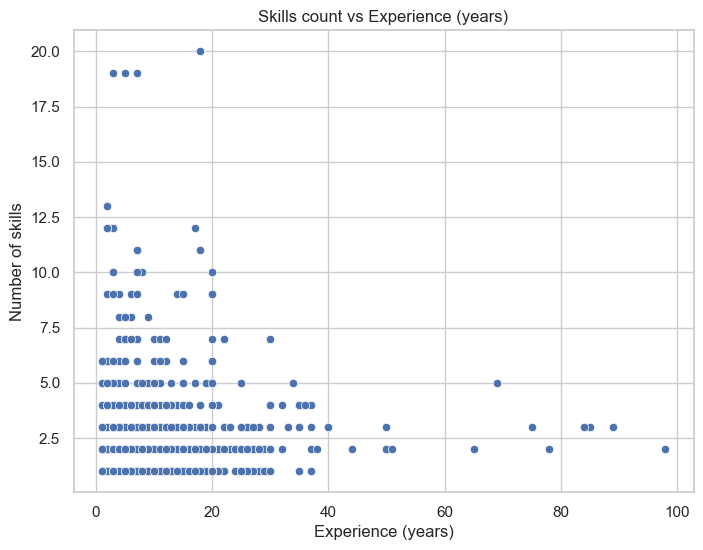

Spearman correlation between experience and number of skills: 0.033


In [29]:
# Boxplot: number of skills by degree presence
plt.figure(figsize=(8,5))
sns.boxplot(x='has_degree', y='num_skills', data=df)
plt.xlabel("Has degree detected")
plt.ylabel("Number of skills")
plt.title("Number of skills: Degree vs No Degree")
plt.show()

# Scatter: skills count vs experience
plt.figure(figsize=(8,6))
sns.scatterplot(x='exp_years', y='num_skills', data=df.replace({'exp_years':{-1:np.nan}}))
plt.title("Skills count vs Experience (years)")
plt.xlabel("Experience (years)")
plt.ylabel("Number of skills")
plt.show()

# Compute Spearman correlation (robust to non-normal)
valid = df['exp_years']>=0
corr = df.loc[valid, ['exp_years','num_skills']].corr(method='spearman').iloc[0,1]
print("Spearman correlation between experience and number of skills:", round(corr,3))


In [30]:
# Expand degrees lists
df_degs = df.explode('degrees')
deg_counts = df_degs['degrees'].value_counts().reset_index()
deg_counts.columns = ['degree','count']
deg_counts

# Pie chart
fig = px.pie(deg_counts, names='degree', values='count', title='Degree distribution (detected)')
fig.show()


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Top unigrams (excluding stopwords)
cv_uni = CountVectorizer(stop_words='english', max_features=40)
bag_uni = cv_uni.fit_transform(df['resume_clean'])
sum_words = bag_uni.sum(axis=0)
words_freq = [(w, sum_words[0, idx]) for w, idx in cv_uni.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:30]
print("Top unigrams:", words_freq[:20])

# Bigrams
cv_bi = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=40)
bag_bi = cv_bi.fit_transform(df['resume_clean'])
sum_bi = bag_bi.sum(axis=0)
bigrams_freq = [(w, sum_bi[0, idx]) for w, idx in cv_bi.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)[:30]
print("Top bigrams:", bigrams_freq[:20])


Top unigrams: [('state', 16156), ('company', 15212), ('city', 15077), ('management', 12174), ('sales', 8275), ('customer', 7927), ('business', 7866), ('skills', 7729), ('new', 6407), ('service', 6223), ('team', 6073), ('development', 5731), ('training', 5637), ('experience', 5632), ('project', 5362), ('work', 4817), ('manager', 4534), ('information', 4502), ('marketing', 4489), ('financial', 4227)]
Top bigrams: [('city state', 14107), ('company city', 9903), ('customer service', 3062), ('project management', 1198), ('current company', 1177), ('microsoft office', 1145), ('university city', 1101), ('high school', 1069), ('business development', 914), ('communication skills', 841), ('human resources', 819), ('public relations', 783), ('social media', 760), ('problem solving', 759), ('bachelor science', 720), ('business administration', 669), ('information technology', 658), ('2014 company', 653), ('college city', 637), ('policies procedures', 627)]


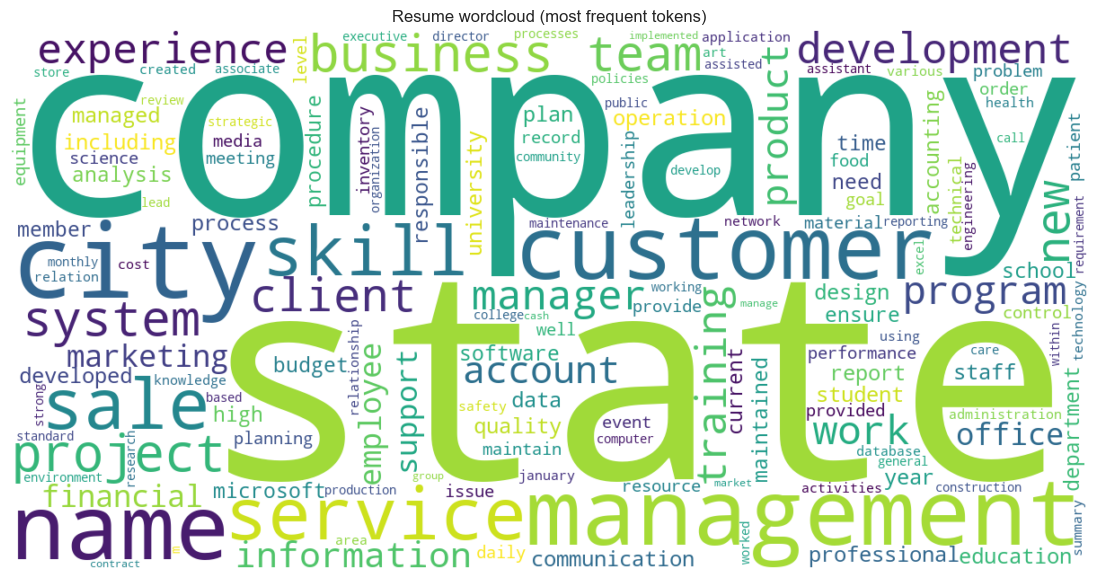

In [32]:
# Create corpus
corpus = " ".join(df['resume_clean'].dropna().values)
wc = WordCloud(width=1200, height=600, background_color='white', collocations=False, max_words=150).generate(corpus)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Resume wordcloud (most frequent tokens)")
plt.show()


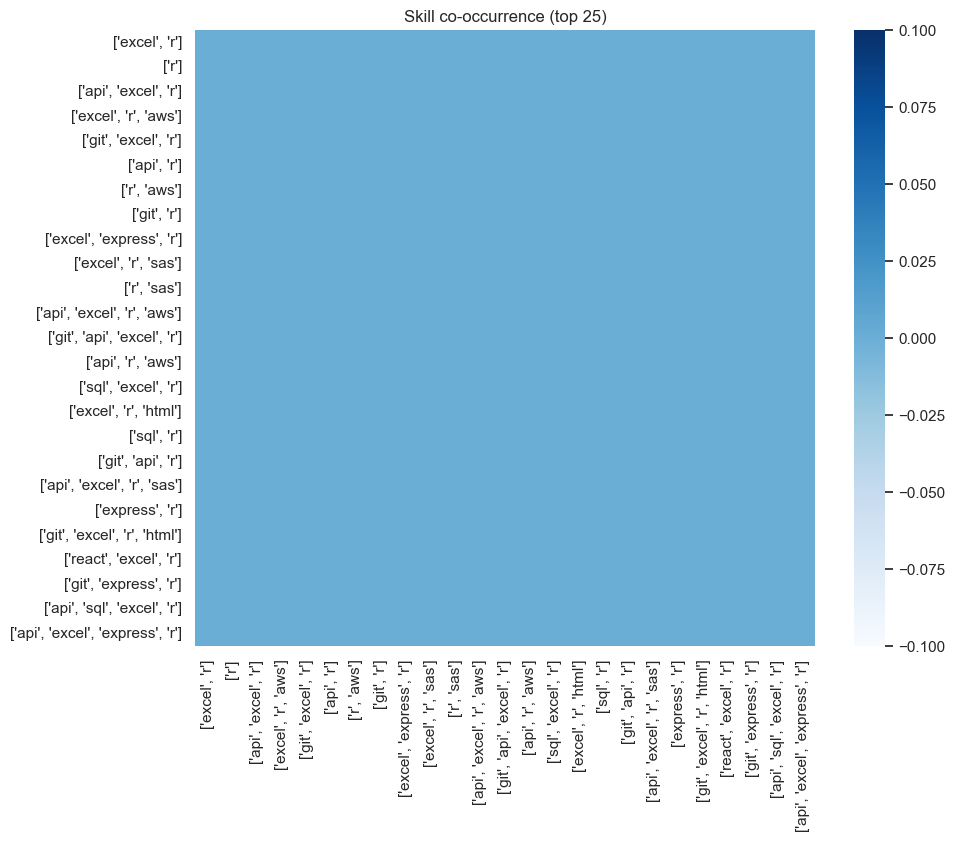

In [33]:
# Build skill co-occurrence matrix for top N skills
top_n = 25
top_skills = skill_counts.head(top_n)['skill'].tolist()

# Create binary matrix
skill_bin = pd.DataFrame(0, index=df.index, columns=top_skills)
for s in top_skills:
    skill_bin[s] = df['skills_found'].apply(lambda x: 1 if s in (x if isinstance(x,list) else []) else 0)

cooc = skill_bin.T.dot(skill_bin)  # co-occurrence counts

plt.figure(figsize=(10,8))
sns.heatmap(cooc, annot=False, cmap='Blues')
plt.title("Skill co-occurrence (top {})".format(top_n))
plt.show()


In [34]:
summary = {
    'Total Resumes': [len(df)],
    'Avg Words': [df['resume_len_words'].mean()],
    'Median Experience (yrs)': [df.loc[df['exp_years']>=0,'exp_years'].median()],
    'Avg Num Skills': [df['num_skills'].mean()],
    '% With Degree Detected': [df['has_degree'].mean()*100]
}
summary_df = pd.DataFrame(summary)
display(summary_df.T)


,0
Total Resumes,2483.000000
Avg Words,811.979863
Median Experience (yrs),10.000000
Avg Num Skills,2.655658
% With Degree Detected,58.880387
